## Running hyperparameter optimization - Part 2

This notebook goes through part two of the steps and codes for identifying the optimal hyperparameter settings for the Variational Autoencoder framework for integrating multi-omics and clinical data spanning both categorical and continuous variables. <br>

The optimal settings are identified based on multiple steps cosidering both reconstruction on the test and training sets as well as the stability/similiarity of the latent space in case of repeated training. Part one focus on the test and training reconstruction accuracies using in <i>MOVE_hyperparameter_optimization_reconstruction.ipynb</i>. From those results the optimal combination are then tested for stability of the latent space in repeated training using this notebook.

In [2]:
#!pip uninstall umap
!pip install umap-learn


ERROR: ld.so: object '/usr/local/lib/AppProtection/libAppProtection.so' from /etc/ld.so.preload cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/usr/local/lib/AppProtection/libAppProtection.so' from /etc/ld.so.preload cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/usr/local/lib/AppProtection/libAppProtection.so' from /etc/ld.so.preload cannot be preloaded (cannot open shared object file): ignored.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: ld.so: object '/usr/local/lib/AppProtection/libAppProtection.so' from /etc/ld.so.preload cannot be preloaded (cannot open shared object file): ignored.
You should consider upgrading via the '/snap/jupyter/6/bin/python -m pip install --upgrade pip' command.


In [3]:
# Import functions
import os, sys
import torch
import numpy as np
from torch.utils import data

from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset

# import umap
import umap.umap_ as umap

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from scipy.stats.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import pandas as pd
import seaborn as sns
import matplotlib
import re
import random
from collections import defaultdict

path="/"
sys.path.append(path + "src/")
import VAE_v2_1

/home/valentas/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


Below are the funcitons for reading data and calculations defiend

In [4]:
# Functions for reading data
def read_cat(file):
   data = np.load(file)
   data = data.astype(np.float32)
   data_input = data.reshape(data.shape[0], -1)
   
   return data, data_input

def read_con(file):
   data = np.load(file)
   data = data.astype(np.float32)
   data[np.isnan(data)] = 0
   consum = data.sum(axis=0)
   mask_col = consum != 0
   data = data[:,mask_col]
   
   return data, mask_col

def read_header(file, mask=None, start=1):
   with open(file, "r") as f:
      h = f.readline().rstrip().split("\t")[start:]
   
   if not mask is None:
      h = np.array(h)
      h = h[mask]
   
   return h

In [5]:
# Functions for calculations
def cal_cat_recon(cat_shapes, cat_recon, cat_class):
   cat_true_recon = []
   cat_total_recon = []
   pos = 0
   for s in cat_shapes:
      n = s[1]
      cat_class_tmp = cat_class[:,pos:(n + pos)]
      cat_recon_tmp = cat_recon[:,pos:(n + pos)]
      
      missing_cat = cat_recon_tmp[cat_class_tmp == -1]
      diff_cat = cat_class_tmp - cat_recon_tmp
      
      diff_cat[diff_cat != 0] = -1
      true_cat = diff_cat[diff_cat == 0]
      false_cat = diff_cat[diff_cat != 0]
      cat_true = len(true_cat)/(float(diff_cat.size) - missing_cat.size)
      cat_true_recon.append(cat_true)
      diff_cat[diff_cat == 0] = 1
      diff_cat[diff_cat != 1] = 0
      cat_total_recon.append(np.count_nonzero(diff_cat, 1) / diff_cat.shape[1])
      pos += n
   return cat_total_recon

def cal_con_recon(train_loader, con_recon, con_shapes):
   total_shape = 0
   true_recon = []
   cos_values = []
   all_values = []
   for s in con_shapes:
      cor_con = list()
      cos_con = list()
      all_val =list()
      for n in range(0, con_recon.shape[0]):
         con_no_missing = train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)][train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)] != 0]
         if len(con_no_missing) <= 1:
            all_val.append(np.nan)
            continue
         con_out_no_missing = con_recon[n,total_shape:(s + total_shape - 1)][train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)] != 0]
         cor = pearsonr(con_no_missing, con_out_no_missing)[0]
         cor_con.append(cor)
         
         com = np.vstack([con_no_missing, con_out_no_missing])
         cos = cosine_similarity(com)[0,1]
         cos_con.append(cos)
         all_val.append(cos)
      
      cor_con = np.array(cor_con)
      cos_con = np.array(cos_con)
      cos_values.append(cos_con)
      all_values.append(np.array(all_val))
      true_recon.append(len(cos_con[cos_con >= 0.7]) / len(cos_con))
      total_shape += s
      
   return true_recon

The next part is for reading in the data. This example uses the different datatypes included in the publication of MOVE which consist of three categorical datatypes and seven continuous. NOTE the data is not availble for testing. 

In [6]:
path = './'
# Read in categorical data
cat, cat_input = read_cat(path + "data/baseline_categorical.npy")
cat_h = read_header(path + "data/baseline_categorical.tsv")

geno, geno_input = read_cat(path + "data/diabetes_genotypes.npy")
geno_h = read_header(path + "data/diabetes_genotypes.tsv")

drug, drug_input = read_cat(path + "data/baseline_drugs.npy")
drug_h = read_header(path + "data/baseline_drugs.tsv")


# Read in continuous data
con, con_mask = read_con(path + "data/baseline_continuous.npy")
con_h = read_header(path + "data/baseline_continuous.tsv", con_mask)

diet_wearables, con_mask = read_con(path + "data/baseline_diet_wearables.npy")
diet_wearables_h = read_header(path + "data/baseline_diet_wearables.tsv", con_mask)

pro, con_mask = read_con(path + "data/baseline_proteomic_antibodies.npy")
pro_h = read_header(path + "data/baseline_proteomic_antibodies.tsv", con_mask)
pro_h = [s + "_pro" for s in pro_h] # due to overlap in gene names form transcriptomics data

target_mata, con_mask = read_con(path + "data/baseline_target_metabolomics.npy")
targm_h = read_header(path + "data/baseline_target_metabolomics.tsv", con_mask)

untarget_mata, con_mask = read_con(path + "data/baseline_untarget_metabolomics.npy")
untargm_h = read_header(path + "data/baseline_untarget_metabolomics.tsv", con_mask)

trans, con_mask = read_con(path + "data/baseline_transcriptomics.npy")
tran_h = read_header(path + "data/baseline_transcriptomics.tsv", con_mask)

metagen, con_mask = read_con(path + "data/baseline_metagenomics.npy")
meta_h = read_header(path + "data/baseline_metagenomics.tsv", con_mask)

In [7]:
# combined headers
con_names = np.concatenate((con_h, diet_wearables_h, pro_h, targm_h, untargm_h, tran_h, meta_h))
cat_names = np.concatenate((cat_h, geno_h, drug_h))

For this part we use all the data contraty to part 1 where it was divided into trainig and test, and investigate how similar the latent space is between the repeated runs. Below we define the selected hyper-parameter settings with equal or close to equal performance based on part 1. For plotting purposes we only test on three different "types" here being size of the hidden layer (nHidden), size of the latent space (nLatents) and the drop-out (drop_outs). The number of hidden lasyers are set to 1 (nl=1). We here repeat the traininng 5 times. 

In [8]:
# If using GPU set to TRUE
cuda = False #cuda = True
device = torch.device("cuda" if cuda == True else "cpu")

con_list = [con, diet_wearables, pro, target_mata, untarget_mata, trans, metagen]
cat_list = [cat, geno]

# nHiddens = [1000, 2000]
# nLatents = [50, 100, 200]
# drop_outs = [0.1, 0.3]
# repeat = 5

nHiddens = [1000, 2000]
nLatents = [50, 100, 200]
drop_outs = [0.1, 0.3]
repeat = 2

latents = defaultdict(list)
embeddings = defaultdict(list)
con_recons = defaultdict(list)
cat_recons = defaultdict(list)
recon_acc = defaultdict(list)
los = defaultdict(list)
likelihood = defaultdict(list)
models = defaultdict()

nepochs = 2
#nepochs = 250
nl = 1
lrate=1e-3 #Added
kldsteps=[20, 30, 40, 90] #Added
batchsteps=[50, 100, 150, 200, 250, 300, 350, 400, 450] #Added

Below we run the full grid search. Here we also save the UMAP embeddings for the posibility of a visual investigation of the results.

In [ ]:
for nHidden in nHiddens:
   for nLatent in nLatents:
      for do in drop_outs:
         for r in range(repeat):
            combi = str([nHidden] * nl) + "+" + str(nLatent) + ", Drop-out:" + str(do)
            print(combi)
            
            mask, train_loader = VAE_v2_1.make_dataloader(cat_list=cat_list, con_list=con_list, batchsize= 10)
            
            ncategorical = train_loader.dataset.cat_all.shape[1]
            ncontinuous = train_loader.dataset.con_all.shape[1]
            con_shapes = train_loader.dataset.con_shapes
            cat_shapes = train_loader.dataset.cat_shapes
            
            model = VAE_v2_1.VAE(ncategorical=ncategorical, ncontinuous= ncontinuous,
                              con_shapes=con_shapes, cat_shapes=cat_shapes, nhiddens=[nHidden]*nl,
                              nlatent=nLatent,  beta=0.0001, con_weights=[1,1,1,1,1,1,1],
                              cat_weights=[1,1], dropout=do, cuda=cuda).to(device) #alpha=0.1,
            
            loss = list()
            ce = list()
            sse = list()
            KLD = list()
            kld_w = 0
            l = len(kldsteps)
            r = 20/l 
            update = 1
            epochs = range(1, nepochs + 1)
            for epoch in range(1, nepochs + 1):
               
               if epoch in kldsteps:
                  kld_w = 1/20 * update
                  update += r
               
               if epoch in batchsteps:
                        train_loader = DataLoader(dataset=train_loader.dataset,
                                                batch_size=int(train_loader.batch_size * 1.25),
                                                shuffle=True,
                                                drop_last=True,
                                                num_workers=train_loader.num_workers,
                                                pin_memory=train_loader.pin_memory)
               l, c, s, k = model.encoding(train_loader, epoch, lrate, kld_w)
               loss.append(l)
               ce.append(c)
               sse.append(s)
               KLD.append(k)
               
            test_loader = DataLoader(dataset=train_loader.dataset, batch_size=1, drop_last=False,
                           shuffle=False, pin_memory=train_loader.pin_memory) #num_workers=1,
            
            latent, latent_var, cat_recon, cat_class, con_recon, test_loss, test_likelihood = model.latent(test_loader, kld_w)
            con_recon = np.array(con_recon)
            con_recon = torch.from_numpy(con_recon)
            
            cat_true_recon = cal_cat_recon(cat_shapes, cat_recon, cat_class)
            true_recon = cal_con_recon(train_loader, con_recon, con_shapes)
            
            ### Umap clustering 
            reducer = umap.UMAP()
            embedding = reducer.fit_transform(latent)
            
            # save
            recon_acc[combi].append(cat_true_recon + true_recon)
            latents[combi].append(latent)
            embeddings[combi].append(embedding)
            con_recons[combi].append(con_recon)
            cat_recons[combi].append(cat_recon)


[1000]+50, Drop-out:0.1
	Epoch: 1	Loss: 10774.562413	CE: 2.9950491	SSE: 10771.567420	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 9760.789483	CE: 3.0171204	SSE: 9757.772411	KLD: 0.0000	Batchsize: 10
====> Test set loss: 4856105.5637


/home/valentas/snap/jupyter/common/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:319: UserWarning: Could not obtain multiprocessing lock due to OS level error: [Errno 13] Permission denied
A likely cause of this problem is '/dev/shm' is missing orread-only such that necessary semaphores cannot be written.
*** The responsibility of ensuring multiprocessing safe access to this initialization sequence/module import is deferred to the user! ***

  warnings.warn(msg % str(e))


[1000]+50, Drop-out:0.1
	Epoch: 1	Loss: 10777.920602	CE: 2.9939433	SSE: 10774.926696	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 9761.171461	CE: 3.0183453	SSE: 9758.153160	KLD: 0.0000	Batchsize: 10
====> Test set loss: 12121975.4251
[1000]+50, Drop-out:0.3
	Epoch: 1	Loss: 10793.912802	CE: 2.9820062	SSE: 10790.930812	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 9862.045546	CE: 3.0033165	SSE: 9859.042246	KLD: 0.0000	Batchsize: 10
====> Test set loss: 3758854479.6216
[1000]+50, Drop-out:0.3
	Epoch: 1	Loss: 10791.807654	CE: 2.9840070	SSE: 10788.823675	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 9849.918290	CE: 2.9967358	SSE: 9846.921554	KLD: 0.0000	Batchsize: 10
====> Test set loss: 2392448796956699.5000
[1000]+100, Drop-out:0.1
	Epoch: 1	Loss: 10774.637794	CE: 2.9813539	SSE: 10771.656398	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 9753.110197	CE: 3.0128476	SSE: 9750.097341	KLD: 0.0000	Batchsize: 10
====> Test set loss: 59072414.5356
[1000]+100, Drop-out:0.1
	Epoch: 1	Loss: 10774.157227	CE: 2.98294

In [ ]:
# Saving the results
np.save(path + "hyperparameters/embedding_stab.npy", embeddings)
np.save(path + "hyperparameters/latent_stab.npy", latents)
np.save(path + "hyperparameters/con_recon_stab.npy", con_recons)
np.save(path + "hyperparameters/cat_recon_stab.npy", cat_recons)
np.save(path + "hyperparameters/recon_acc_stab.npy", recon_acc)

In [10]:
# Run if you want to reload the results
embeddings = np.load(path + "hyperparameters/embedding_stab.npy", allow_pickle = True).item()
latents = np.load(path + "hyperparameters/latent_stab.npy", allow_pickle = True).item()
con_recons = np.load(path + "hyperparameters/con_recon_stab.npy", allow_pickle = True).item()
cat_recons = np.load(path + "hyperparameters/cat_recon_stab.npy", allow_pickle = True).item()
recon_acc = np.load(path + "hyperparameters/recon_acc_stab.npy", allow_pickle = True).item()

Below is calcualtion and visualisation only focusig on the top 10 closest neigbour for each individual

In [11]:
npatient = cat.shape[0] #added

# Top 10 changes
top10_changes = defaultdict(list)
stability_top10 = defaultdict(list)
for nHidden in nHiddens:
   for nLatent in nLatents:
      for do in drop_outs:
          max_pos_values_init = list()
          old_sum_max = list()
          #name = str([nHidden] * nl) + "+" + str(nLatent)
          name = str([nHidden] * nl) + "+" + str(nLatent) + ", Drop-out:" + str(do)

          top10_changes[name] = [ [] for i in range(npatient) ]
          for r in range(repeat):
             cos_sim = cosine_similarity(latents[name][r])

             corr = pd.DataFrame(cos_sim)
             step = list()
             for index, row in corr.iterrows():
                if r == 0:
                   max_pos = np.asarray(row.argsort()[11:][::-1][1:11])
                   max_pos_values_init.append(max_pos)
                   #summed_max = np.mean(row[max_pos])
                   old_sum_max.append(row[max_pos])
                else:
                   old_pos = max_pos_values_init[index]
                   old_sum = old_sum_max[index]
                   #summed_max = np.mean(row[old_pos])
                   top10_changes[name][index].append(np.mean(abs(old_sum - row[old_pos])))
                   step.append(np.mean(abs(old_sum - row[old_pos])))

             if r != 0:
                stability_top10[name].append(np.mean(step))

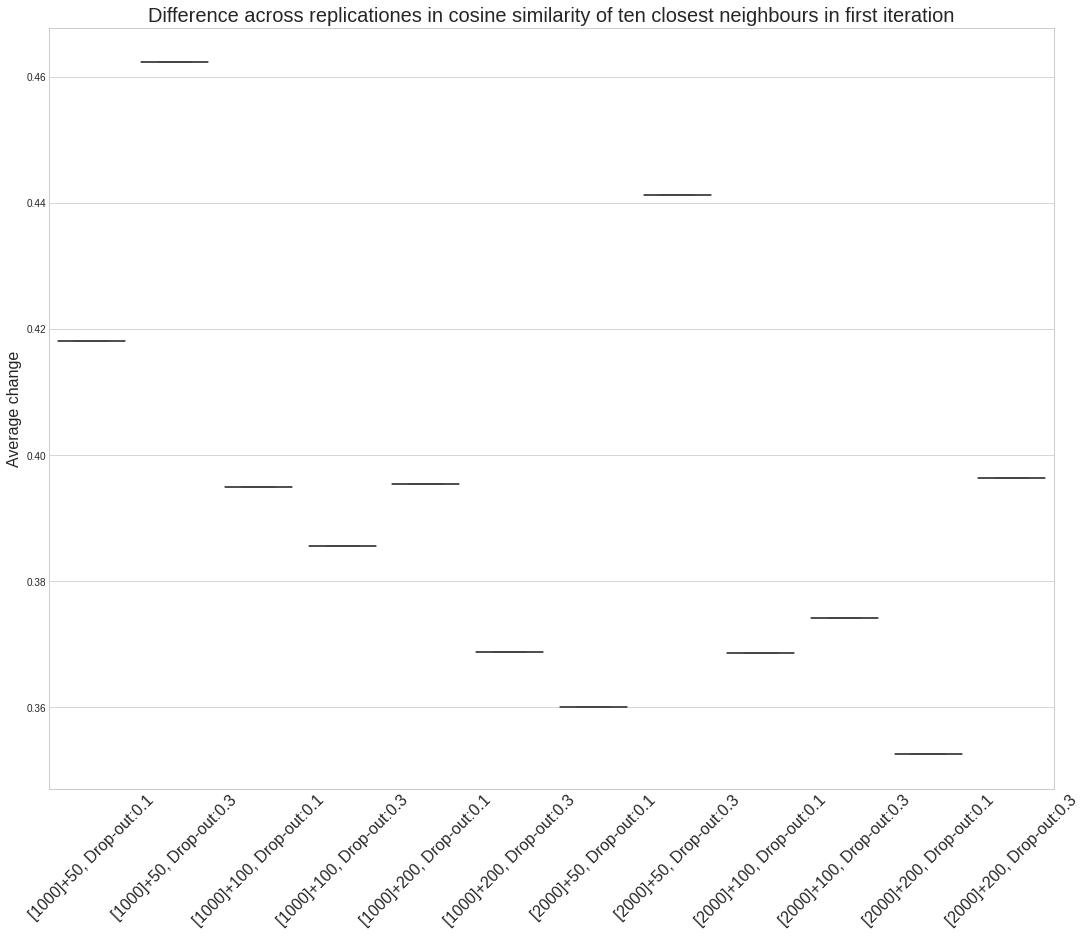

In [12]:
# Plot hidden+latent combination differnces
sns.set_color_codes("dark")
df = pd.DataFrame(stability_top10)
df_t = df.T

fig = plt.figure(figsize=(18,14))
ax = sns.boxplot(data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, size=16)
plt.title('Difference across replicationes in cosine similarity of ten closest neighbours in first iteration', size=20)
plt.ylabel("Average change", size=16)
plt.xlabel('')
plt.savefig(path + "hyperparameters/stability_top10.png")
# plt.clf()

The next part compared based on all of the latent space. Furthermore, it includes code for calculation on cluster stability if the latent space is to be used for clustering (not used by MOVE in the paper here only cosine similarity on latent is included).

In [13]:
# repeat = 2
rand_index_baseline = list()
# First it looks at the 
ran_index_baseline = []
for d in range(repeat):
   if d == 0:
      kmeans = KMeans(n_clusters=4)
      kmeans = kmeans.fit(latents[name][0])
      true_labels = kmeans.predict(latents[name][0])
   else:
      kmeans = KMeans(n_clusters=4)
      kmeans = kmeans.fit(latents[name][0])
      labels = kmeans.predict(latents[name][0])
      ran_index_baseline.append(adjusted_rand_score(true_labels, labels)) #Changed to adjusted_rand_score


rand_avg_baseline = np.mean(ran_index_baseline)

total_changes = defaultdict(list)
stability_total = defaultdict(list)
rand_index = defaultdict(list)
nl = 1
for nHidden in nHiddens:
   for nLatent in nLatents:
      for do in drop_outs:
         pos_values_init = list()
         old_rows = list()
         name = str([nHidden] * nl) + "+" + str(nLatent) + ", Drop-out:" + str(do)
         total_changes[name] = [ [] for i in range(npatient) ]
         for r in range(repeat):
            cos_sim = cosine_similarity(latents[name][r])
            
            corr = pd.DataFrame(cos_sim)
            step = list()
            for index, row in corr.iterrows():
               if r == 0:
                  max_pos = np.asarray(row.argsort()[:][::-1][1:])
                  pos_values_init.append(max_pos)
                  old_rows.append(row[max_pos])
               else:
                  old_pos = pos_values_init[index]
                  old_row = old_rows[index]
                  total_changes[name][index].append(np.mean(abs(old_row - row[old_pos])))
                  step.append(np.mean(abs(old_row - row[old_pos])))
            
            if r != 0:
               kmeans = KMeans(n_clusters=4)
               rand_tmp = []
               for i in range(0,100):
                  kmeans = kmeans.fit(latents[name][r])
                  labels = kmeans.predict(latents[name][r])
                  rand_tmp.append(adjusted_rand_score(true_labels, labels)) #Changed to adjusted_rand_score
               
               rand_index[name].append(np.mean(rand_tmp))
               stability_total[name].append(np.mean(step))
            else:
               kmeans = KMeans(n_clusters=4)
               kmeans = kmeans.fit(latents[name][r])
               true_labels = kmeans.predict(latents[name][r])

df = pd.DataFrame(stability_total)

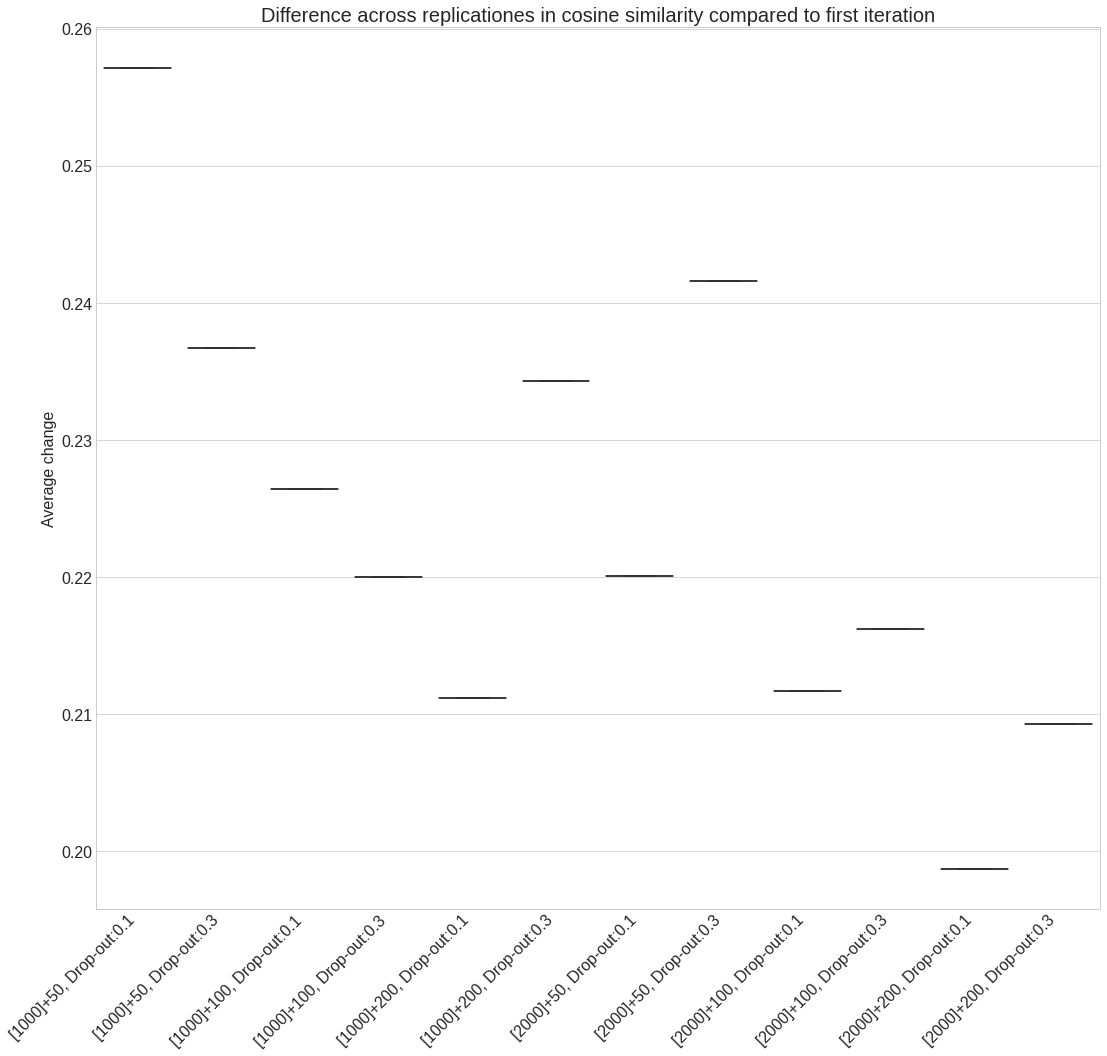

In [14]:
# Plot stability
fig = plt.figure(figsize=(18,18))
ax = sns.boxplot(data=df, palette = sns.color_palette('colorblind', df.shape[1]))
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, size=16, horizontalalignment='right')
plt.title('Difference across replicationes in cosine similarity compared to first iteration', size=20)
plt.ylabel("Average change", size=16)
plt.yticks(fontsize=16)
#plt.xlabel('Hyperparameter setting')
plt.xlabel('')
fig.subplots_adjust(bottom=0.2)
plt.savefig(path + "hyperparameters/stability_all.png")
# plt.clf()

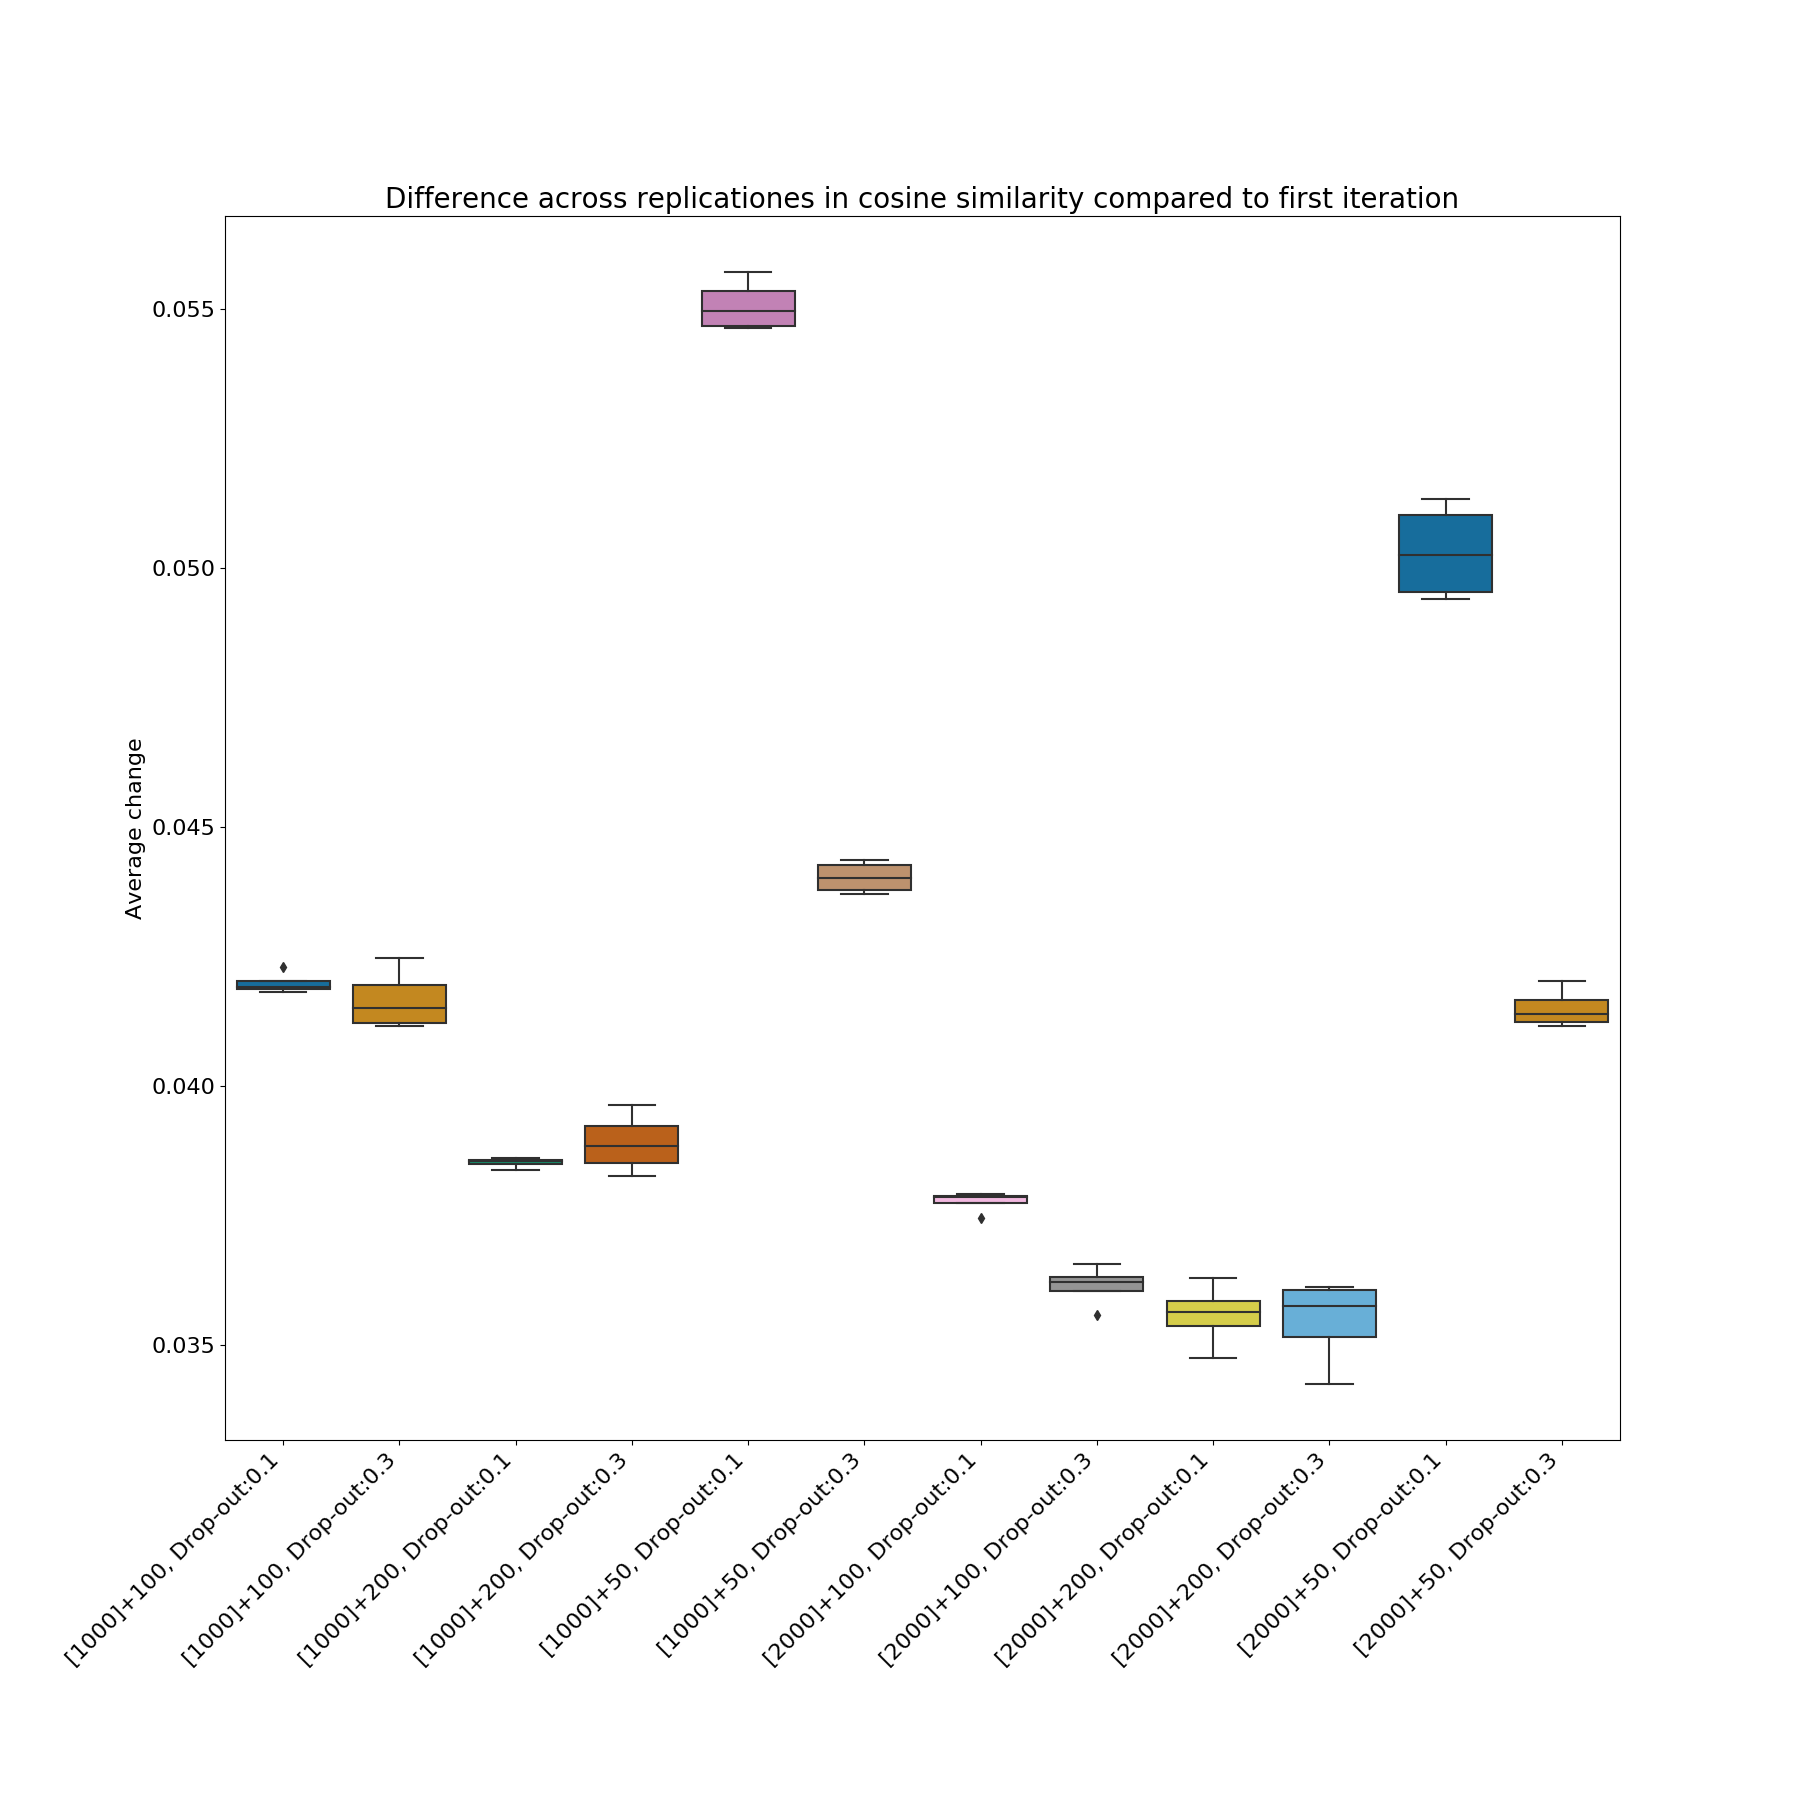

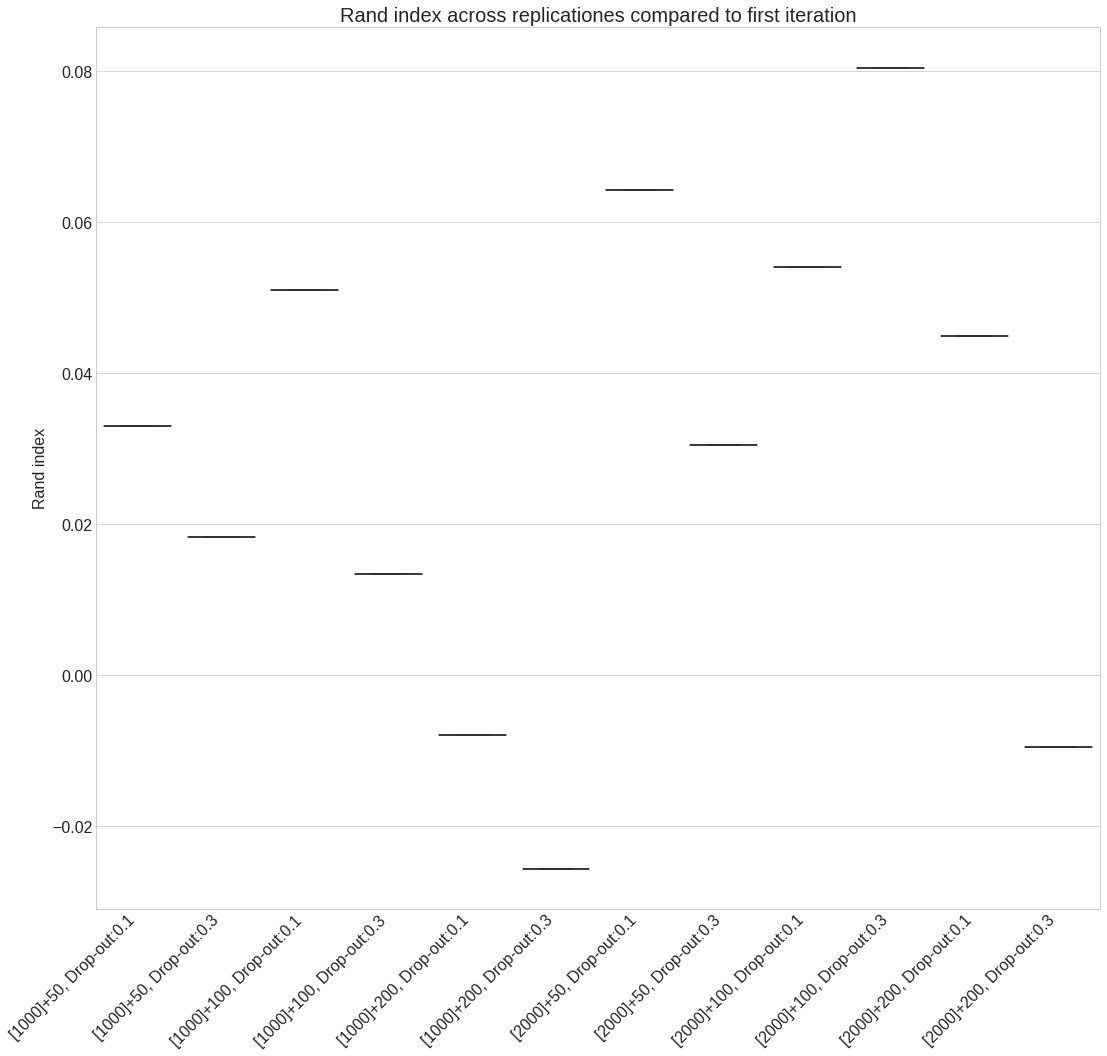

In [15]:
# Plot rand index
df = pd.DataFrame(rand_index)
fig = plt.figure(figsize=(18,18))
ax = sns.boxplot(data=df, palette = sns.color_palette('colorblind', df.shape[1]))
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, size=16, horizontalalignment='right')
plt.title('Rand index across replicationes compared to first iteration', size=20)
plt.ylabel("Rand index", size=16)
plt.yticks(fontsize=16)
#plt.xlabel('Hyperparameter setting')
plt.xlabel('')
fig.subplots_adjust(bottom=0.2)
plt.savefig(path + "hyperparameters/rand_index_all.png")
# plt.clf()

From here on the optimal setting for further analysis can be selected. This includes the framework used in MOVE for identifying drug and multi-omics assosiations as descriped in the notebook <i>identify_drug_assosiation.ipynb</i>, compare the latent space integration to other methods (PCA) using the notebook <i>latent_space_analysis.ipynb</i> or for other types of analysis such as clustering of the latent space (not included here). 